In [112]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures

In [114]:
# read in the CSV files & data cleaning
# Load the datasets
batting_stats_1524 = pd.read_csv('batting1524.csv')
batting_stats_1524.head(5)

# data cleaning
# making sure there are no missing values
data = batting_stats_1524.dropna(subset=['hit', 'ab'])
data.tail()

,"last_name, first_name",player_id,year,ab,pa,hit,k_percent,bb_percent,batting_avg,slg_percent,...,b_total_sacrifices,woba,xwoba,sweet_spot_percent,barrel_batted_rate,hard_hit_percent,avg_best_speed,avg_hyper_speed,whiff_percent,swing_percent
1370,"Chourio, Jackson",694192,2024,528,573,145,21.1,6.8,0.275,0.464,...,3,0.339,0.328,33.2,7.8,44.9,100.832970,94.831073,27.1,48.8
1371,"Schanuel, Nolan",694384,2024,519,607,130,17.0,11.2,0.250,0.362,...,10,0.315,0.321,36.4,3.5,25.4,95.305191,91.662607,14.4,41.8
1372,"Langford, Wyatt",694671,2024,499,557,126,20.6,9.2,0.253,0.415,...,3,0.321,0.331,31.3,9.3,43.4,101.211099,94.807366,22.9,42.8
1373,"Young, Jacob",696285,2024,468,521,120,19.6,5.8,0.256,0.331,...,11,0.290,0.286,28.1,1.6,28.9,96.872142,92.486925,19.3,44.9
1374,"Merrill, Jackson",701538,2024,554,593,162,17.0,4.9,0.292,0.500,...,9,0.352,0.372,39.6,11.3,43.9,100.811785,94.735707,20.5,56.9


In [116]:
# Data Preprocessing (getting data ready for analysis)
# Drop any rows with missing target values (e.g., batting average for future prediction)
data = batting_stats_1524.dropna(subset=['hit', 'ab'])

# Convert appropriate columns to numeric (excluding non-numeric columns)
numeric_columns = ['year', 'ab', 'pa', 'hit', 'k_percent', 'bb_percent', 'batting_avg', 'slg_percent',
                   'b_total_sacrifices', 'woba', 'xwoba', 'sweet_spot_percent', 'barrel_batted_rate',
                   'hard_hit_percent', 'avg_best_speed', 'avg_hyper_speed', 'whiff_percent', 'swing_percent']

data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows with missing values in numeric columns
data = data.dropna(subset=numeric_columns)
# Drop columns not useful for prediction
features = data.drop(columns=['last_name, first_name', 'player_id', 'year', 'batting_avg'])
labels = data['batting_avg']

# Feature Scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [118]:
# Feature Engineeering (transforming raw data into meaningful data)
# Calculate Batting Average (BA) as hits/at-bats
data['batting_average'] = data['hit'] / data['ab']

# Calculate additional features
# On-Base Percentage (OBP)
data['on_base_percent'] = (data['hit'] + data['bb_percent'] * data['pa']) / (data['ab'] + data['bb_percent'] * data['pa'])

# Slugging Percentage (SLG)
data['slugging_percent'] = data['slg_percent']

# On-Base Plus Slugging (OPS)
data['ops'] = data['on_base_percent'] + data['slugging_percent']

# Batting Efficiency (Hits per Plate Appearance)
data['batting_efficiency'] = data['hit'] / data['pa']

# Weighted Plate Discipline (Walks vs Strikeouts)
data['plate_discipline'] = data['bb_percent'] / (data['k_percent'] + 1e-5)

# Hard Hit Efficiency (Hard Hit Percentage * Barrel Rate)
data['hard_hit_efficiency'] = data['hard_hit_percent'] * data['barrel_batted_rate']

# Interaction terms between selected features
data['batting_avg_on_base_interaction'] = data['batting_average'] * data['on_base_percent']

# Polynomial features (degree 2) for selected numerical features
poly = PolynomialFeatures(degree=2, include_bias=False)
selected_features = data[['batting_average', 'on_base_percent', 'ops', 'hard_hit_efficiency']]
poly_features = poly.fit_transform(selected_features)
poly_feature_names = poly.get_feature_names_out(['batting_average', 'on_base_percent', 'ops', 'hard_hit_efficiency'])

# Creating a DataFrame for polynomial features
poly_features_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=data.index)

# Log transformations for skewed features (ensure values are non-negative before applying log1p)
data['log_ops'] = np.log1p(data['ops'])
data['log_hard_hit_efficiency'] = np.log1p(data['hard_hit_efficiency'])

# Concatenate new features to the dataset
data_with_engineered_features = pd.concat([data, poly_features_df], axis=1)
# Rounding the engineered features to 3 decimal places for clarity
data_with_engineered_features = data_with_engineered_features.round(3)

# Displaying the updated dataset to the user
data_with_engineered_features.head()

,"last_name, first_name",player_id,year,ab,pa,hit,k_percent,bb_percent,batting_avg,slg_percent,...,batting_average^2,batting_average on_base_percent,batting_average ops,batting_average hard_hit_efficiency,on_base_percent^2,on_base_percent ops,on_base_percent hard_hit_efficiency,ops^2,ops hard_hit_efficiency,hard_hit_efficiency^2
0,"Hunter, Torii",116338,2015,521,567,125,18.5,6.2,0.240,0.409,...,0.058,0.216,0.315,41.867,0.813,1.182,157.380,1.718,228.751,30450.250
1,"Ortiz, David",120074,2015,528,614,144,15.5,12.5,0.273,0.553,...,0.074,0.260,0.411,175.421,0.909,1.436,613.100,2.269,968.795,413719.104
2,"Rodriguez, Alex",121347,2015,523,620,131,23.4,13.5,0.250,0.486,...,0.063,0.239,0.361,119.856,0.914,1.378,457.417,2.079,689.973,228971.820
3,"Ramirez, Aramis",133380,2015,475,516,117,13.2,6.0,0.246,0.423,...,0.061,0.222,0.326,47.588,0.810,1.190,173.831,1.750,255.555,37326.240
4,"Beltré, Adrian",134181,2015,567,619,163,10.5,6.6,0.287,0.453,...,0.083,0.263,0.393,63.878,0.834,1.248,202.905,1.866,303.561,49372.840



Summary Statistics:

           player_id         year           ab           pa          hit  \
count    1375.000000  1375.000000  1375.000000  1375.000000  1375.000000   
mean   565717.890909  2019.394182   504.750545   566.031273   134.779636   
std     87258.147444     2.867571   115.926222   129.475798    35.808607   
min    116338.000000  2015.000000   154.000000   186.000000    32.000000   
25%    514888.000000  2017.000000   480.000000   535.000000   121.000000   
50%    592206.000000  2019.000000   530.000000   594.000000   139.000000   
75%    641487.000000  2022.000000   576.000000   649.000000   158.000000   
max    807799.000000  2024.000000   681.000000   753.000000   217.000000   

         k_percent   bb_percent  batting_avg  slg_percent  on_base_percent  \
count  1375.000000  1375.000000  1375.000000  1375.000000      1375.000000   
mean     20.022982     8.917382     0.265940     0.451252         0.925085   
std       5.518663     3.169420     0.028395     0.065794  

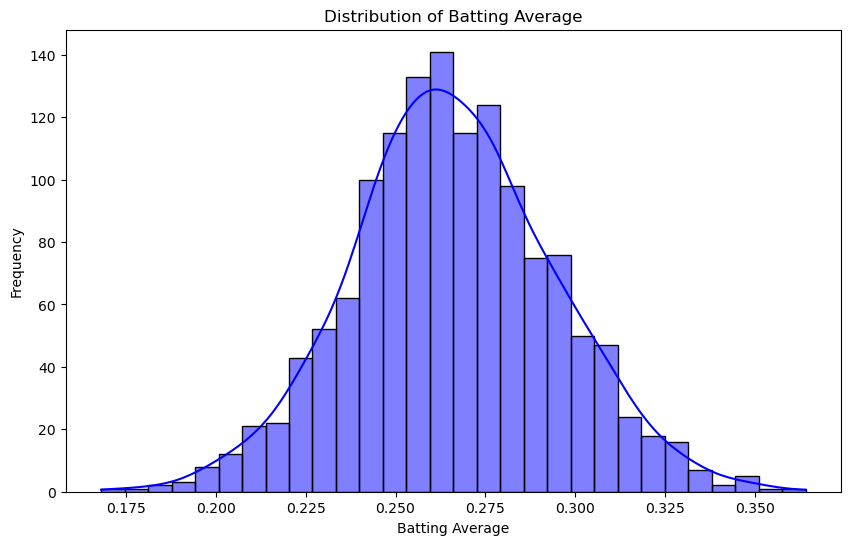

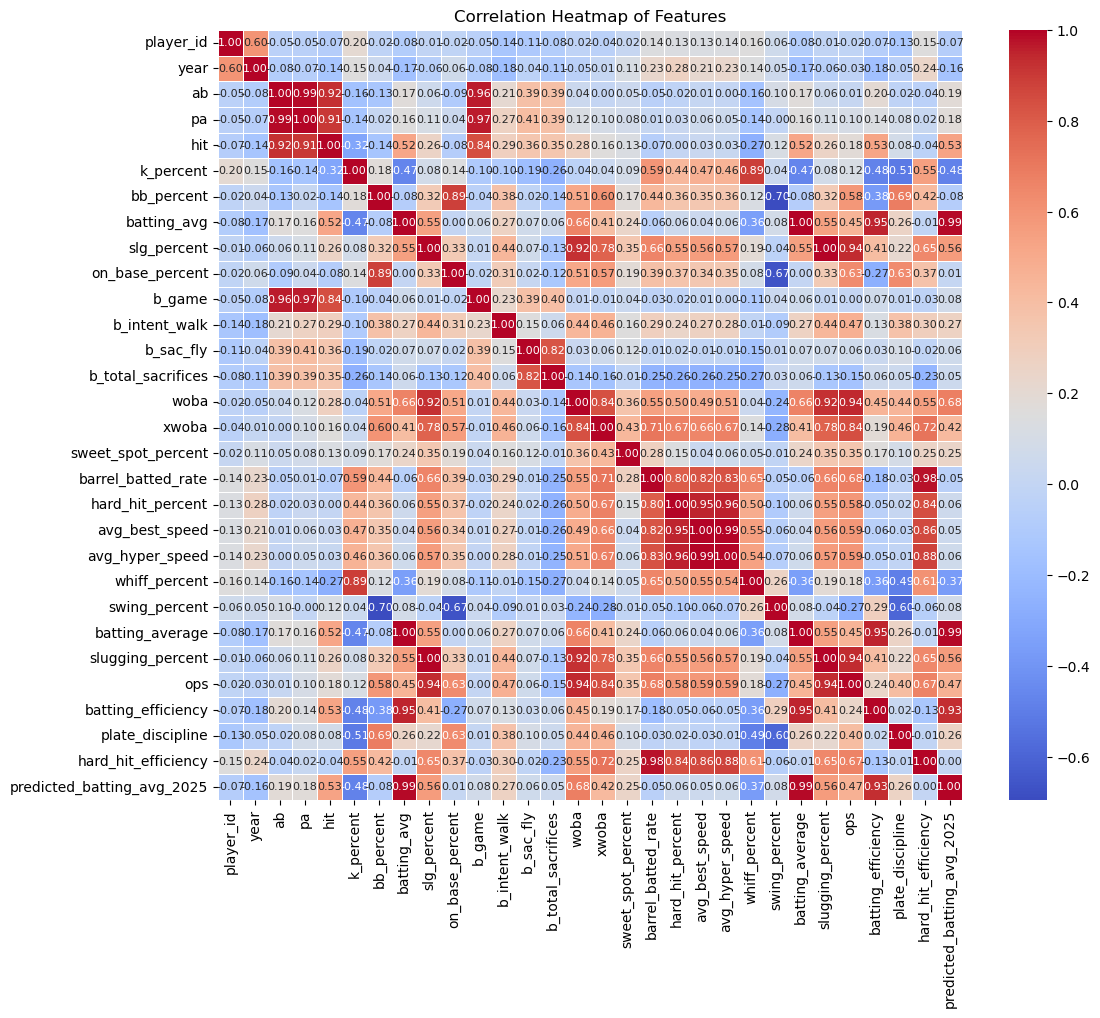

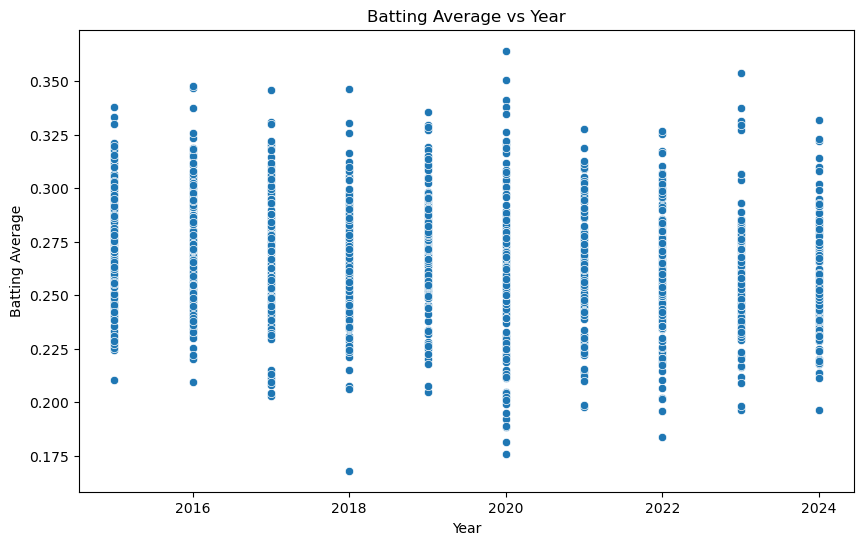

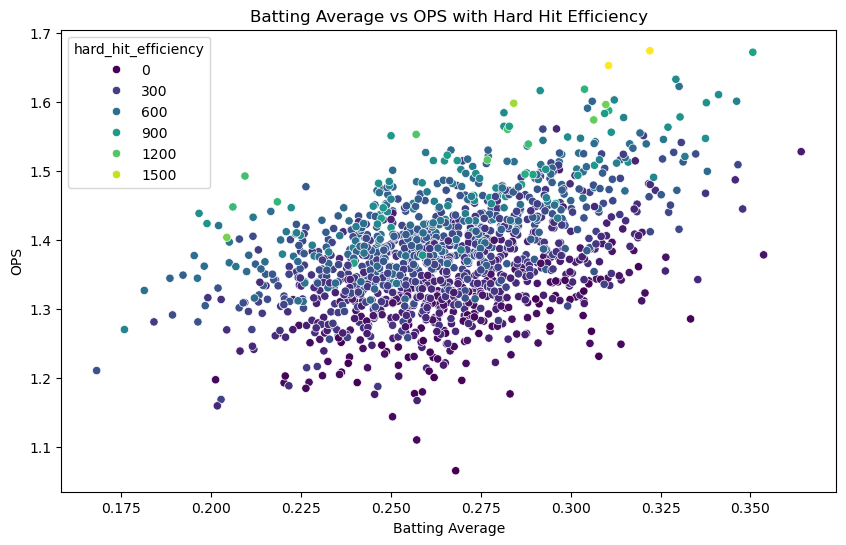

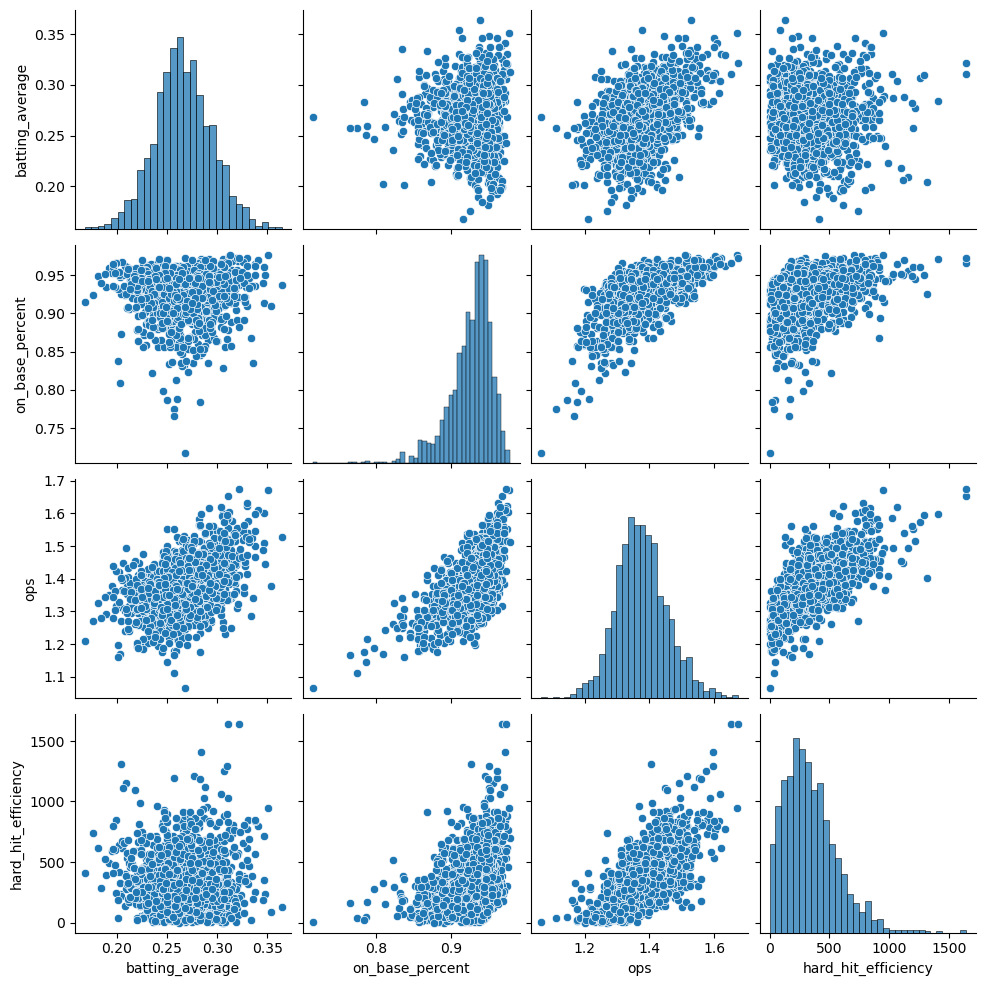

In [83]:
# Exploratory Data Analysis
# Summary Statistics
print("\nSummary Statistics:\n")
print(data.describe())

# Distribution of Batting Average
plt.figure(figsize=(10, 6))
sns.histplot(data['batting_average'], kde=True, color='blue', bins=30)
plt.title('Distribution of Batting Average')
plt.xlabel('Batting Average')
plt.ylabel('Frequency')
plt.show()

# Ensure all relevant columns are numeric
numeric_data = data.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 10))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f", annot_kws={"size": 8})
plt.title('Correlation Heatmap of Features')
plt.show()

# Scatter Plot: Batting Average vs Year
plt.figure(figsize=(10, 6))
sns.scatterplot(x='year', y='batting_average', data=data)
plt.title('Batting Average vs Year')
plt.xlabel('Year')
plt.ylabel('Batting Average')
plt.show()

# Scatter plot of batting_average vs ops
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='batting_average', y='ops', hue='hard_hit_efficiency', palette='viridis')
plt.title('Batting Average vs OPS with Hard Hit Efficiency')
plt.xlabel('Batting Average')
plt.ylabel('OPS')
plt.show()

# pairplot
sns.pairplot(data, vars=['batting_average', 'on_base_percent', 'ops', 'hard_hit_efficiency'])


Cross-Validation Mean Squared Error: 0.00002803


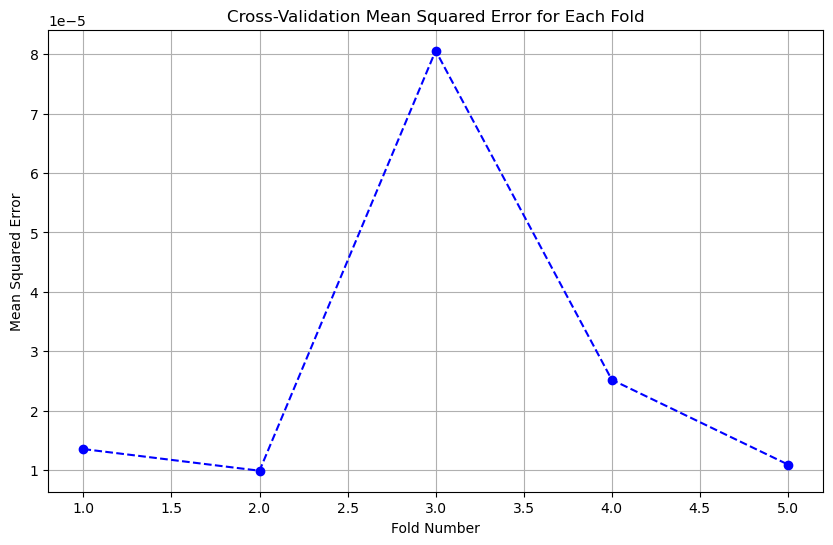

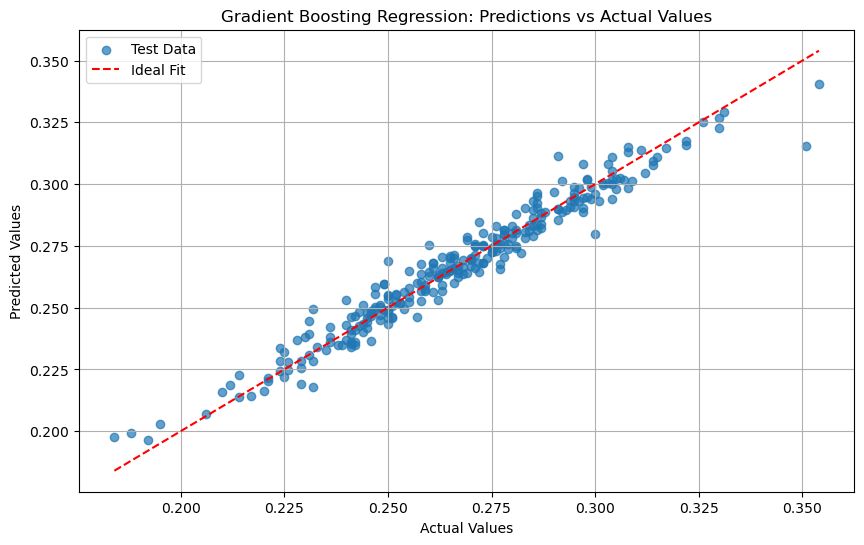

Training MSE: 0.000014
Training R²: 0.982311
Testing MSE: 0.000038
Testing R²: 0.952448


In [91]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Cross-validation
cv_scores = cross_val_score(model, features_scaled, labels, cv=5, scoring='neg_mean_squared_error')
mean_cv_mse = -np.mean(cv_scores)
print(f"Cross-Validation Mean Squared Error: {mean_cv_mse:.8f}")
# Visualize Cross-Validation MSE
cv_mse_scores = -cv_scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cv_mse_scores) + 1), cv_mse_scores, marker='o', linestyle='--', color='b')
plt.xlabel('Fold Number')
plt.ylabel('Mean Squared Error')
plt.title('Cross-Validation Mean Squared Error for Each Fold')
plt.grid(True)
plt.show()

#Gradient Regression
# Split the data
features_train, features_test, labels_train, labels_test = train_test_split(
    features_scaled, labels, test_size=0.2, random_state=42
)

# Initialize and train the model
model = GradientBoostingRegressor(random_state=42)
model.fit(features_train, labels_train)

# Predict for 2025
predictions_2025 = model.predict(features_scaled)
data['predicted_batting_avg_2025'] = predictions_2025.round(3)
modelGBR = GradientBoostingRegressor()
modelGBR.fit(features_train, labels_train)

# Predict test values
y_test_pred = model.predict(X_test)

# Evaluate model on training and testing data
y_train_pred = model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Visualization of Predictions vs Actual Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, label='Test Data')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal Fit')
plt.title('Gradient Boosting Regression: Predictions vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# Print Evaluation Metrics
print(f"Training MSE: {train_mse:.6f}")
print(f"Training R²: {train_r2:.6f}")
print(f"Testing MSE: {test_mse:.6f}")
print(f"Testing R²: {test_r2:.6f}")


In [78]:
# Predict the 2025 batting averages
predictions_2025 = model.predict(features_scaled)
data['predicted_batting_avg_2025'] = predictions_2025.round(3)

# Display results
# Display players that played in 2024 with their predicted 2025 batting average
players_2024 = data[data['year'] == 2024]
# Display results
pd.set_option('display.max_rows', None)  # Show all rows in the data frame
print(players_2024[['last_name, first_name', 'batting_avg', 'predicted_batting_avg_2025']])

       last_name, first_name  batting_avg  predicted_batting_avg_2025
1246       McCutchen, Andrew        0.232                       0.235
1247          Turner, Justin        0.259                       0.263
1248         Santana, Carlos        0.238                       0.242
1249       Goldschmidt, Paul        0.245                       0.244
1250            Altuve, Jose        0.295                       0.291
1251        Freeman, Freddie        0.282                       0.280
1252         Perez, Salvador        0.271                       0.274
1253          Ozuna, Marcell        0.302                       0.300
1254          Semien, Marcus        0.237                       0.239
1255    Springer III, George        0.220                       0.222
1256           Harper, Bryce        0.285                       0.285
1257         Suárez, Eugenio        0.256                       0.257
1258          Arenado, Nolan        0.272                       0.272
1259       Walker, C